In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils
from analyze_fits import analyze_gabor_params

import copy
import cmocean


from utils import prf_utils,numpy_utils
import scipy.stats


import numpy as np
from utils import circ_utils
from feature_extraction import gabor_feature_extractor


In [4]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


In [5]:
# Load results of the fitting procedure
subjects = np.arange(1,9)
# subjects=[1]
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]
fig_save_folder=None

skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

In [6]:
# using the corr coef between model resp and feature channel activation as a measure of selectivity.

feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
preferred_ori_corr[is_constant] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
preferred_sf_corr[is_constant] = np.nan


In [7]:
# Do some analyses on the orientation/frequency selectivity profiles - find their peaks

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

n_ori_peaks, top_orients = analyze_gabor_params.analyze_orient_peaks(est_tuning_curves=mean_orient_corr, \
                                                                 val_r2 = val_r2, \
                                                                 r2_cutoff=0.01, peak_thresh=0.50,\
                                                                 ori_unique = ori_unique);

n_freq_peaks, top_freqs = analyze_gabor_params.analyze_freq_peaks(est_tuning_curves=mean_sf_corr, \
                                                                 val_r2 = val_r2, \
                                                                 r2_cutoff=0.01, peak_thresh=0.50,\
                                                                 sf_unique = sf_unique);

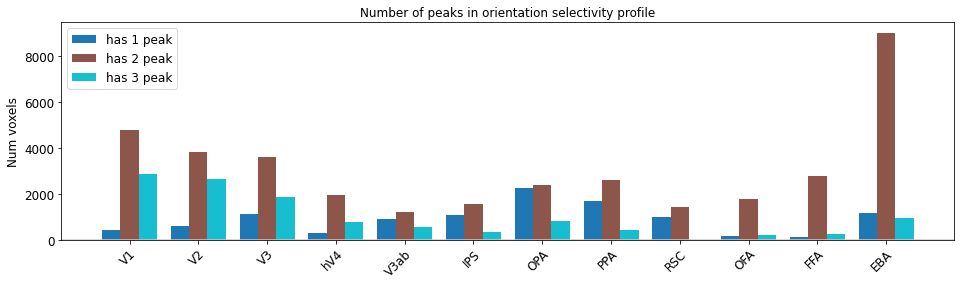

In [8]:
n_ori_peaks_vals = np.arange(1,4)
roi_counts_n_ori_peaks = np.zeros((n_rois,len(n_ori_peaks_vals)),dtype=int)
for ri in range(n_rois):
    inds = roi_def.get_indices(ri)
    roi_counts_n_ori_peaks[ri,:] = [np.sum(n_ori_peaks[inds]==pp) for pp in n_ori_peaks_vals]
    
vals = roi_counts_n_ori_peaks
# vals = roi_counts_n_ori_peaks/np.sum(roi_counts_n_ori_peaks, axis=1, keepdims=True)
labels = ['has %d peak'%pp for pp in n_ori_peaks_vals]

fh = plot_utils.plot_multi_bars(mean_data=vals, space=0.1, \
                xticklabels=roi_names, ylabel='Num voxels', \
                ylim=[], title='Number of peaks in orientation selectivity profile', horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

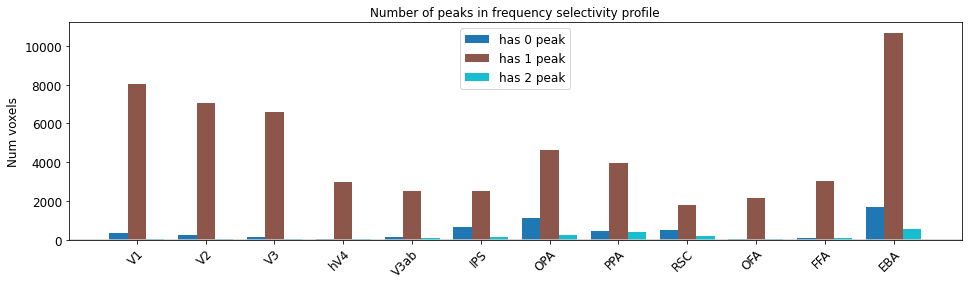

In [9]:
n_freq_peaks_vals = np.arange(0,3)
roi_counts_n_freq_peaks = np.zeros((n_rois,len(n_freq_peaks_vals)),dtype=int)
for ri in range(n_rois):
    inds = roi_def.get_indices(ri)
    roi_counts_n_freq_peaks[ri,:] = [np.sum(n_freq_peaks[inds]==pp) for pp in n_freq_peaks_vals]
    
vals = roi_counts_n_freq_peaks
# vals = roi_counts_n_freq_peaks/np.sum(roi_counts_n_freq_peaks, axis=1, keepdims=True)
labels = ['has %d peak'%pp for pp in n_freq_peaks_vals]

fh = plot_utils.plot_multi_bars(mean_data=vals, space=0.1, \
                xticklabels=roi_names, ylabel='Num voxels', \
                ylim=[], title='Number of peaks in frequency selectivity profile', horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

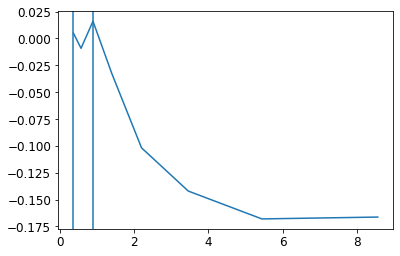

In [12]:
vinds = np.where(roi_def.get_indices(11) & (val_r2>0.01) & (n_freq_peaks==2))[0]
vidx = np.random.choice(vinds, 1)[0]
plt.figure();
plt.plot(sf_unique, mean_sf_corr[vidx,:])
n = int(n_freq_peaks[vidx])
for ff in range(n):
    plt.axvline(top_freqs[vidx,ff])
# plt.plot(top_freqs[vidx,0:n], mean_sf_corr[vidx,top_freqs[vidx,0:n]],'.')

In [13]:
which_bimodal_group, top_bimodal_pairs, bimodal_pair_labels = \
        analyze_gabor_params.group_bimodal_voxels(n_ori_peaks, top_orients, n_groups_use=3)

which_trimodal_group, top_trimodal_pairs, trimodal_pair_labels = \
        analyze_gabor_params.group_trimodal_voxels(n_ori_peaks, top_orients, n_groups_use=3)


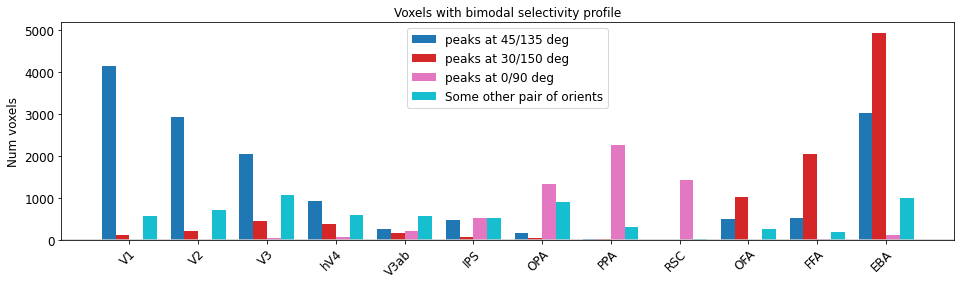

In [14]:
roi_counts_bimodal = np.zeros((n_rois,4),dtype=int)
for ri in range(n_rois):
    inds = roi_def.get_indices(ri)
    roi_counts_bimodal[ri,:] = [np.sum(which_bimodal_group[inds]==pp) for pp in range(4)]

vals = roi_counts_bimodal
# vals = roi_counts_bimodal/np.sum(roi_counts_bimodal, axis=1, keepdims=True)

fh = plot_utils.plot_multi_bars(mean_data=vals, space=0.1, \
                xticklabels=roi_names, ylabel='Num voxels', \
                ylim=[], title='Voxels with bimodal selectivity profile', horizontal_line_pos=0,\
                legend_labels=bimodal_pair_labels, \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

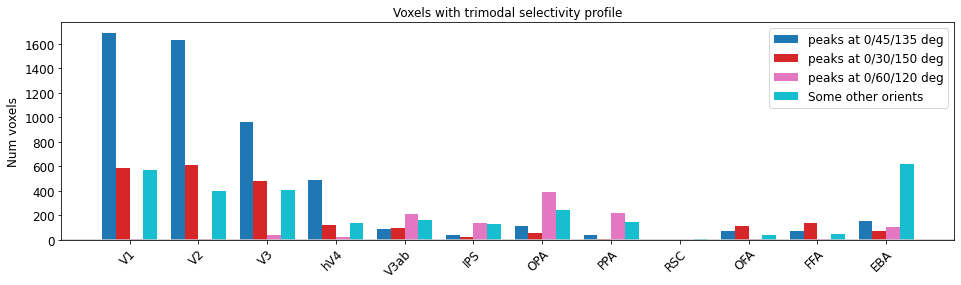

In [15]:
roi_counts_trimodal = np.zeros((n_rois,4),dtype=int)
for ri in range(n_rois):
    inds = roi_def.get_indices(ri)
    roi_counts_trimodal[ri,:] = [np.sum(which_trimodal_group[inds]==pp) for pp in range(4)]
    
vals = roi_counts_trimodal
# vals = roi_counts_trimodal/np.sum(roi_counts_trimodal, axis=1, keepdims=True)

fh = plot_utils.plot_multi_bars(mean_data=vals, space=0.1, \
                xticklabels=roi_names, ylabel='Num voxels', \
                ylim=[], title='Voxels with trimodal selectivity profile', horizontal_line_pos=0,\
                legend_labels=trimodal_pair_labels, \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

[ 45. 135.   0.  nan  nan  nan]


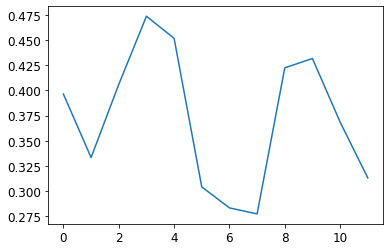

In [16]:
# plotting some examples of the 3-peaked voxels

inds = np.where(roi_def.get_indices(0) & (n_ori_peaks==3))[0]
# vidx = inds[np.flip(np.argsort(val_r2[inds]))][0]
vidx = np.random.choice(inds,1)[0]
profile = mean_orient_corr[vidx,:]
print(top_orients[vidx,:])
plt.figure();
plt.plot(profile)

In [14]:
# Make plots in pycortex for all the parameters

import cortex
from utils import numpy_utils

port=44442

title = 'Gabor model tuning estimates, %s'%(summary_plots.get_substr(out));

names = []
maps = []
cmaps = []
mins = []
maxes = []
vox2plot = []
subject_map_inds = []
map_sequence = []

n_vox_each = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
sub_inds = np.concatenate([si*np.ones(n_vox_each[si],) for si in range(n_subjects)], axis=0)

for si, ss in enumerate(subjects):

    names += ['S%d: Gabor model accuracy (sqrt R2)'%ss]
    maps += [np.sqrt(out[si]['val_r2'][:,0])]
    cmaps += ['PuBu']
    mins += [0]
    maxes += [0.60]

    ori_pref = ori_unique[preferred_ori_corr[sub_inds==si].astype('int')]
    freq_pref = sf_unique[preferred_sf_corr[sub_inds==si].astype('int')]
    maps += [ori_pref, freq_pref]
    names += ['S%d: Preferred orientation (deg)'%ss, 'S%d: Preferred spatial frequency (cyc/deg)'%ss]
    cmaps += ['Retinotopy_RYBCR', 'viridis']
    mins += [0, 0]
    maxes += [180, 9]
      
    maps += [top_orients[sub_inds==si,0], top_orients[sub_inds==si,1]]
    names += ['S%d: first peak orient (deg)'%ss, 'S%d: second peak orient (deg)'%ss]
    cmaps += ['Retinotopy_RYBCR', 'Retinotopy_RYBCR']
    mins += [0, 0]
    maxes += [180, 180]
    
    maps += [n_ori_peaks[sub_inds==si]]
    names += ['S%d: num peaks in selectivity profile'%ss]
    cmaps += ['plasma_r']
    mins += [0]
    maxes += [5]
                        
    maps += [which_bimodal_group[sub_inds==si].astype(np.float32)]
    names += ['S%d: which bimodal group'%ss]
    cmaps += ['viridis']
    mins += [0]
    maxes += [4]
    
    maps += [which_trimodal_group[sub_inds==si].astype(np.float32)]
    names += ['S%d: which trimodal group'%ss]
    cmaps += ['viridis']
    mins += [0]
    maxes += [4]

    vox2plot.append(out[si]['val_r2'][:,0]>0.01)
    
    n_new_maps = int(len(names)/(si+1))
    subject_map_inds += [si for ii in range(n_new_maps)]
    map_sequence += [ni for ni in range(n_new_maps)]

# putting them into a nicer order (want same type of map near each other to compare subs)
_, new_order = numpy_utils.double_sort(np.arange(len(maps)), map_sequence, subject_map_inds)
names = [names[ni] for ni in new_order]
cmaps = [cmaps[ni] for ni in new_order]
mins = [mins[ni] for ni in new_order]
maxes = [maxes[ni] for ni in new_order]
maps = [maps[ni] for ni in new_order]
subject_map_inds = [subject_map_inds[ni] for ni in new_order]


voxel_mask = [o['voxel_mask'] for o in out]
nii_shape = [o['brain_nii_shape'] for o in out]
volume_space = out[0]['volume_space']

pycortex_plot_utils.plot_maps_pycortex(subjects, port, maps, names, subject_map_inds=subject_map_inds, \
                        mins=mins, maxes=maxes, cmaps=cmaps, \
                        title=title, vox2plot = vox2plot, roi_def=None, \
                        voxel_mask =voxel_mask, \
                        nii_shape = nii_shape, \
                        volume_space=volume_space)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


navigate browser to: 127.0.0.1:44442
Started server on port 44442


<JS: window.viewer>

Text(0.5, 0.98, 'Distribution of preferred orientation (max selectivity), all voxels across 8 subjects')

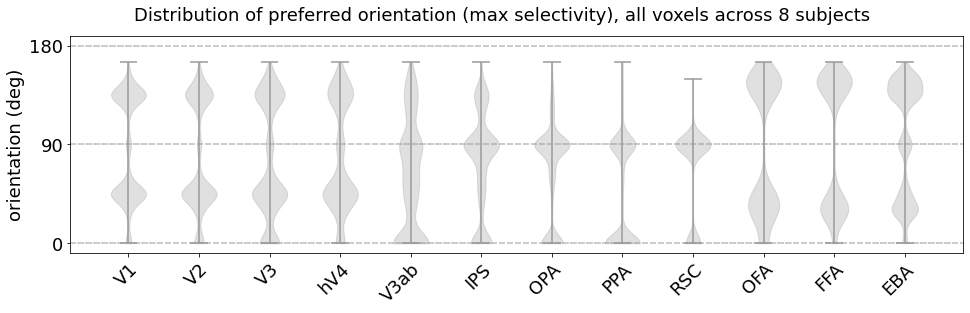

In [17]:

plot_utils.set_all_font_sizes(18)

r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

color = [0.6, 0.6, 0.6]

plt.figure(figsize=(16,4))

for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi].astype(int)],[ri])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

    plt.yticks([0,90,180])
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    
    plt.ylabel('orientation (deg)')

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                       rotation=45, ha='right',rotation_mode='anchor')

plt.suptitle('Distribution of preferred orientation (max selectivity), all voxels across 8 subjects')


Text(0.5, 0.98, 'Distribution of preferred spatial frequency (max selectivity), all voxels across 8 subjects')

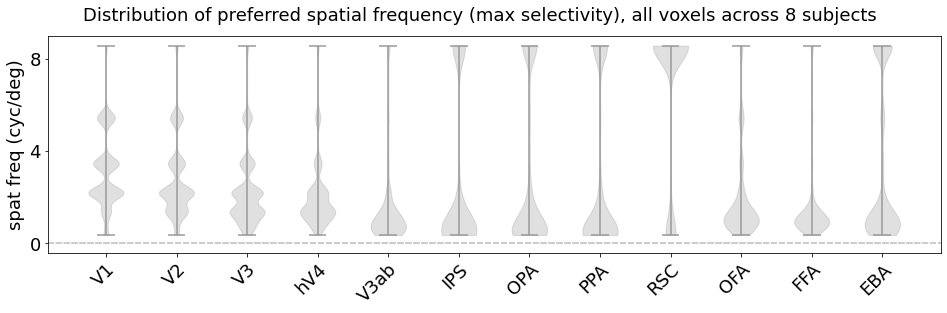

In [18]:

plot_utils.set_all_font_sizes(18)

r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

color = [0.6, 0.6, 0.6]

plt.figure(figsize=(16,4))

for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    parts = plt.violinplot(sf_unique[preferred_sf_corr[inds_this_roi].astype(int)],[ri])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

    plt.yticks([0,4,8])
   
    plt.ylabel('spat freq (cyc/deg)')

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                       rotation=45, ha='right',rotation_mode='anchor')

plt.suptitle('Distribution of preferred spatial frequency (max selectivity), all voxels across 8 subjects')


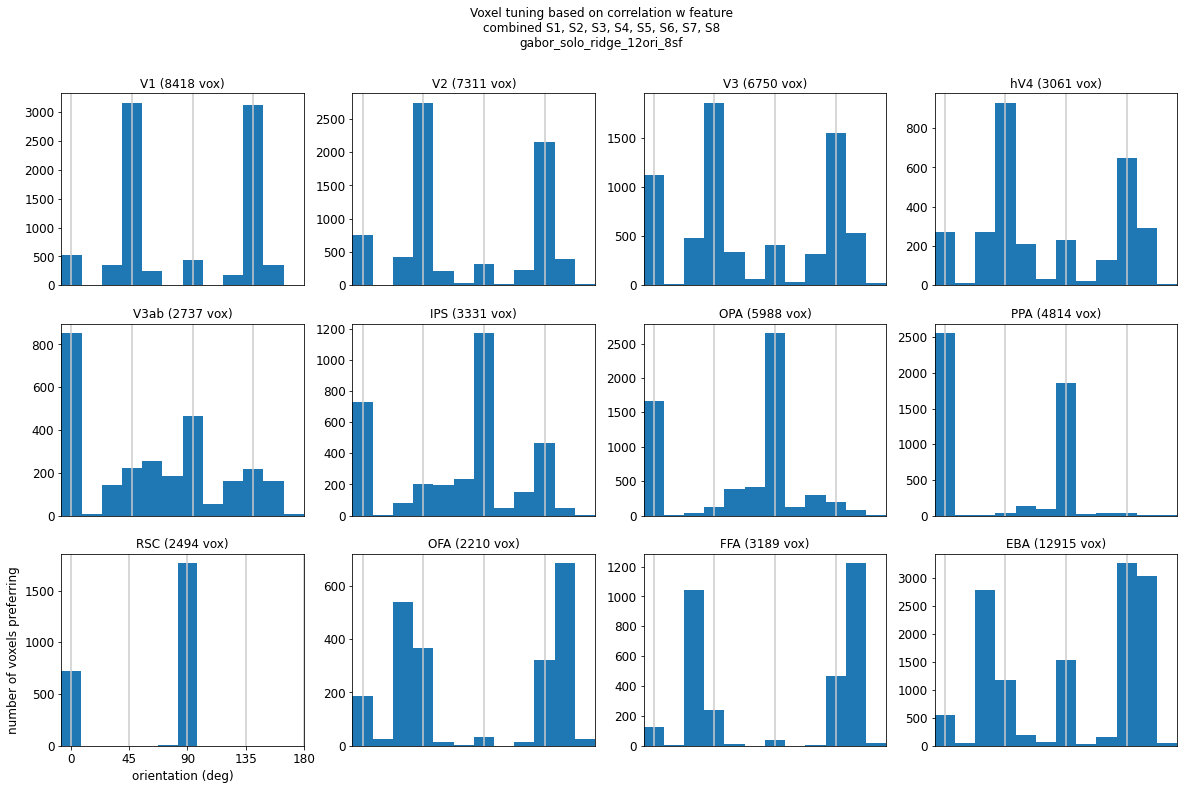

In [35]:
# Plot histograms of "preferred orientation"
# based on correlation coefficient method

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

plot_utils.set_all_font_sizes(12)
plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    spacing = ori_unique[1] - ori_unique[0]
    neach = [np.sum(preferred_ori_corr[inds_this_roi]==oo) for oo in range(n_ori)]
    plt.bar(ori_unique, neach, width=spacing)

    plt.xlim([-spacing/2,180-spacing/2])

    if pi==(npx-1)*npy+1:
        plt.xlabel('orientation (deg)')
        plt.ylabel('number of voxels preferring')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
#         plt.yticks([])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\n%s\n%s'%(summary_plots.get_substr(out), fitting_type));


In [32]:
# compute pRF pars

prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = sigma * screen_eccen_deg

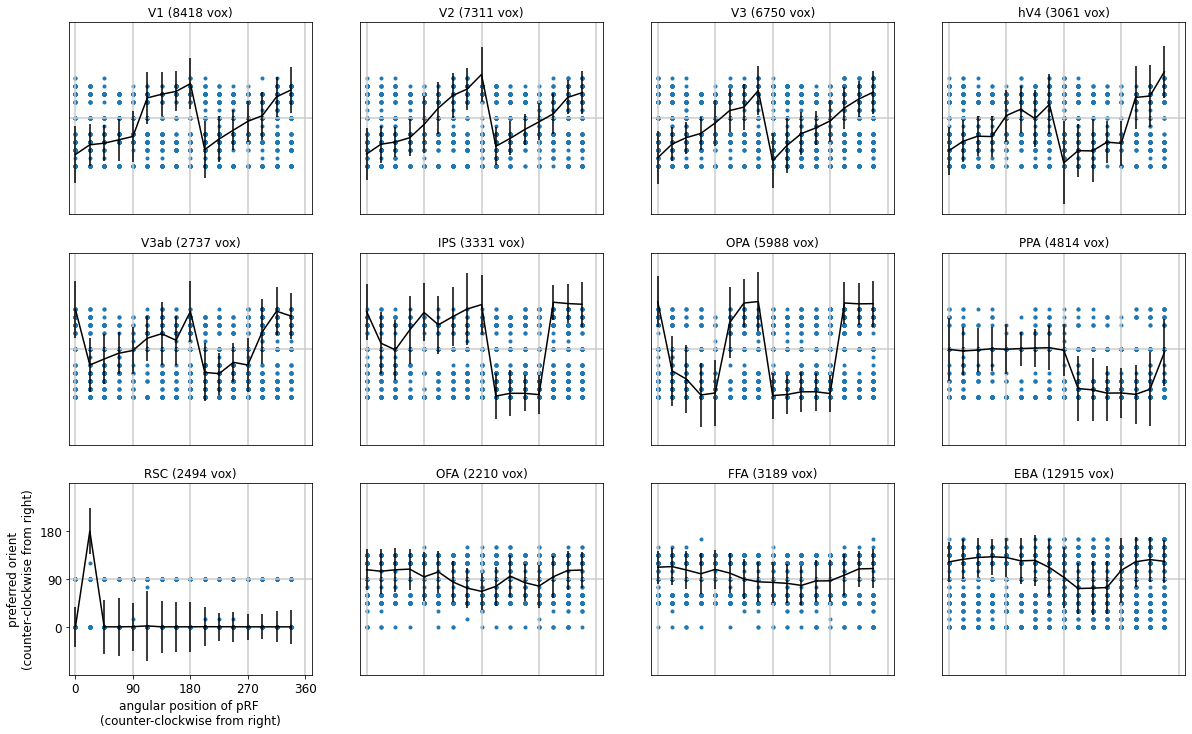

In [45]:
# Plot radial bias

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))


pi=0
for ri in range(n_rois):

    vinds = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    xvals = np.round(angle_fwrf[vinds],1)
    unique_angles, counts = np.unique(xvals, return_counts=True)
    
    # change the coordinate system of orientation here, so that it matches with 
    # the angular positions (go counter-clockwise from right)
    yvals = np.mod(90 - ori_unique[preferred_ori_corr[vinds].astype(int)], 180)  
    # yvals = np.mod(90 - ori_unique[preferred_ori_weights[vinds].astype(int)], 180)  
    yvals_adj = yvals/180*2*np.pi # for circmean/circstd, need range 0-2pi
    
    ymean = np.array([scipy.stats.circmean(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)
    ystd = np.array([scipy.stats.circstd(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)

    plt.plot(xvals, yvals,'.')

    plt.errorbar(unique_angles, ymean, ystd, color='k',zorder=10)

    for ii in np.arange(0,370,90):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])
    plt.axhline(90,color=[0.8, 0.8, 0.8])

    if pi==(npx-1)*npy+1:
        plt.xticks(np.arange(0,370,90));
        plt.yticks(np.arange(0,190,90));
        plt.xlabel('angular position of pRF \n(counter-clockwise from right)')
        plt.ylabel('preferred orient\n(counter-clockwise from right)')
    else:
        plt.xticks([])
        plt.yticks([])
        
    plt.xlim([-10, 370])
    plt.ylim([-90, 270])
        
    plt.title('%s (%d vox)'%(roi_names[ri],np.sum(vinds)))
    

Text(0.5, 0.98, 'orientation prefs in each pRF polar angle bin\nall V1 vox (8418 vox)')

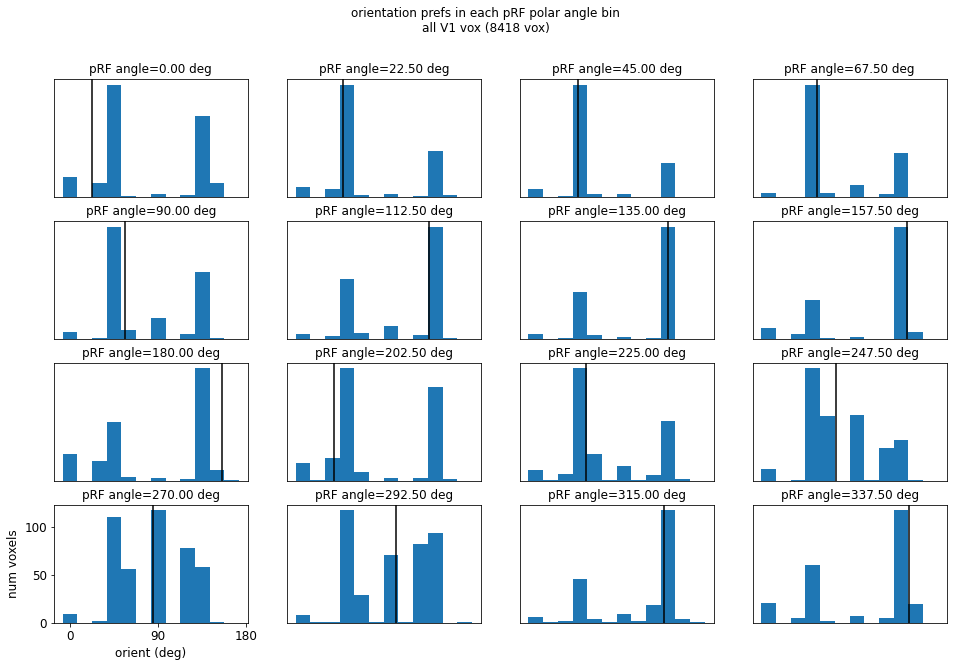

In [75]:
ri = 0;
vinds = roi_def.get_indices(ri) & abv_thresh
vinds
xvals = np.round(angle_fwrf[vinds],1)
unique_angles, counts = np.unique(xvals, return_counts=True)

# change the coordinate system of orientation here, so that it matches with 
# the angular positions (go counter-clockwise from right)
yvals = np.mod(90 - ori_unique[preferred_ori_corr[vinds].astype(int)], 180)  
yvals_adj = yvals/180*2*np.pi

plt.figure(figsize=(16,10))
spacing = ori_unique[1] - ori_unique[0]

for ai, angle in enumerate(unique_angles):
    
    plt.subplot(4,4,ai+1)
    
    angle_inds = xvals==angle
        
    neach = [np.sum(np.round(yvals[angle_inds],1)==np.round(ori,1)) for ori in ori_unique]
    assert(np.sum(neach)==len(yvals[angle_inds]))
    
    plt.bar(ori_unique, neach, width=spacing)
    plt.title('pRF angle=%.2f deg'%angle)
    
    ymean = scipy.stats.circmean(yvals_adj[angle_inds])*180/(2*np.pi)
    ystd = scipy.stats.circstd(yvals_adj[angle_inds])*180/(2*np.pi)
    
    plt.axvline(ymean, color='k')
    
    
    if ai==12:
        plt.xticks([0,90,180])
        plt.xlabel('orient (deg)')
        plt.ylabel('num voxels')
    else:
        plt.xticks([])
        plt.yticks([])
        
        
    
plt.suptitle('orientation prefs in each pRF polar angle bin\nall %s vox (%d vox)'\
             %(roi_names[ri], np.sum(vinds)))


In [85]:
ri = 0;
vinds = roi_def.get_indices(ri) & abv_thresh
vinds
xvals = np.round(angle_fwrf[vinds],1)
unique_angles, counts = np.unique(xvals, return_counts=True)

# change the coordinate system of orientation here, so that it matches with 
# the angular positions (go counter-clockwise from right)
yvals = np.mod(90 - ori_unique[preferred_ori_corr[vinds].astype(int)], 180)  
yvals_adj = yvals/180*2*np.pi

ai = 0;
angle = unique_angles[ai]
angle_inds = xvals==angle
neach = [np.sum(np.round(yvals[angle_inds],1)==np.round(ori,1)) for ori in ori_unique]
assert(np.sum(neach)==len(yvals[angle_inds]))
ymean = scipy.stats.circmean(yvals_adj[angle_inds])*180/(2*np.pi)
ystd = scipy.stats.circstd(yvals_adj[angle_inds])*180/(2*np.pi)


In [68]:
# quantify radial bias, circular corr coefficient

from utils import circ_utils

circ_corrs = np.zeros((n_rois,))

r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff
for ri in range(n_rois):

    vinds = roi_def.get_indices(ri) & abv_thresh
       
    # make this axis span from just 0-180, because 0/180 should have same orient pref
    xvals = np.mod(angle_fwrf[vinds], 180)/180*2*np.pi
   
    # change the coordinate system of orientation here, so that it matches with 
    # the angular positions (go counter-clockwise from right)
    yvals = np.mod(90 - ori_unique[preferred_ori_corr[vinds].astype(int)], 180)/180*2*np.pi 

    circ_corrs[ri] = circ_utils.circ_corr_coef(xvals, yvals)
    
print(circ_corrs)

[ 0.10158314  0.15936378  0.12111984  0.02862854  0.0240964  -0.01148753
 -0.00882441 -0.00377928 -0.00113379 -0.00437239 -0.00140566 -0.00525586]


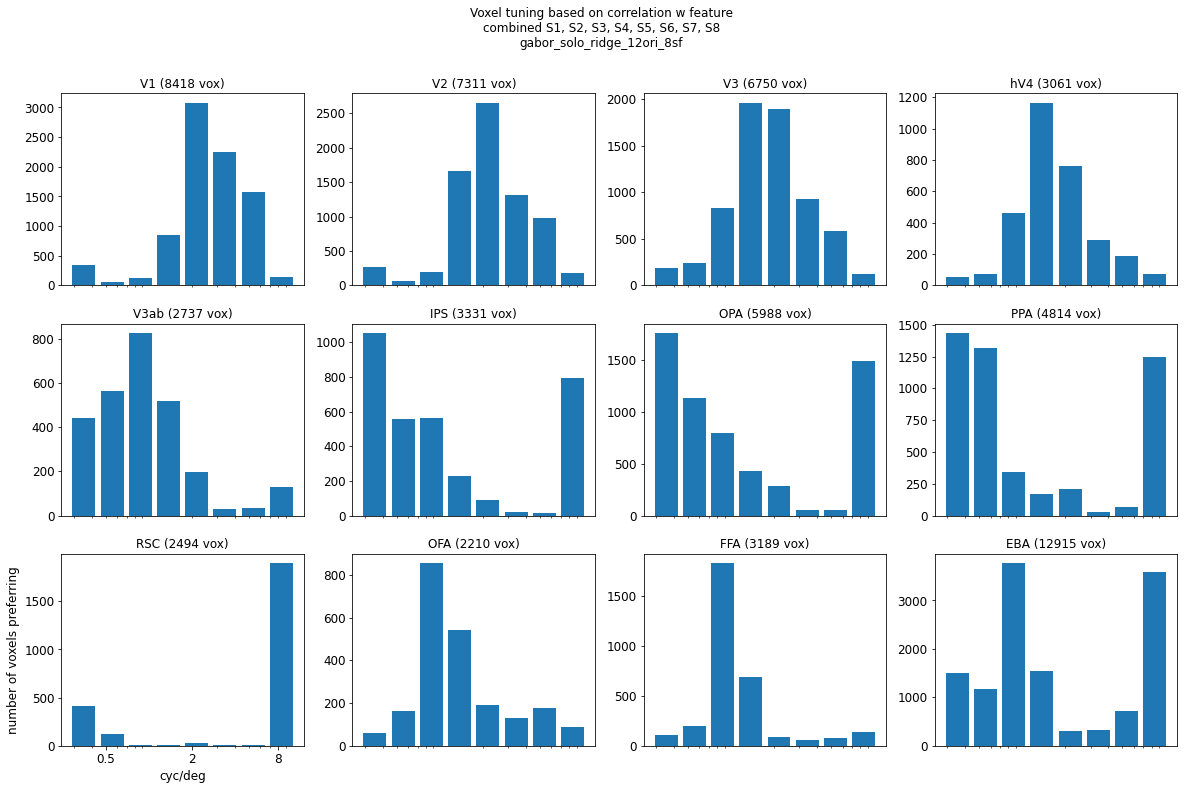

In [20]:
# Plot histograms of "preferred frequency"
# based on correlation coefficient method

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    spacing = np.diff(sf_unique)
    if len(spacing)>1:
        dlog = np.log(spacing[1]) - np.log(spacing[0])                
    else:
        dlog = np.log(sf_unique[1]) - np.log(sf_unique[0])
        plt.xlim([10**np.log10(0.1), 10**np.log10(14)])
    spacing = np.concatenate([[np.exp(np.log(spacing[0]) - dlog)], spacing])
    
    neach = [np.sum(preferred_sf_corr[inds_this_roi]==ff) for ff in range(n_sf)]
    plt.bar(sf_unique, neach, width=spacing)

    
    plt.gca().set_xscale('log')
    if pi==(npx-1)*npy+1:
        plt.xlabel('cyc/deg')
        plt.ylabel('number of voxels preferring')
        plt.xticks([10**np.log10(0.5), 10**np.log10(2),10**np.log10(8)],\
                   [0.5, 2,8])
    else:
        plt.xticks([]);

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\n%s\n%s'\
             %(summary_plots.get_substr(out), fitting_type));


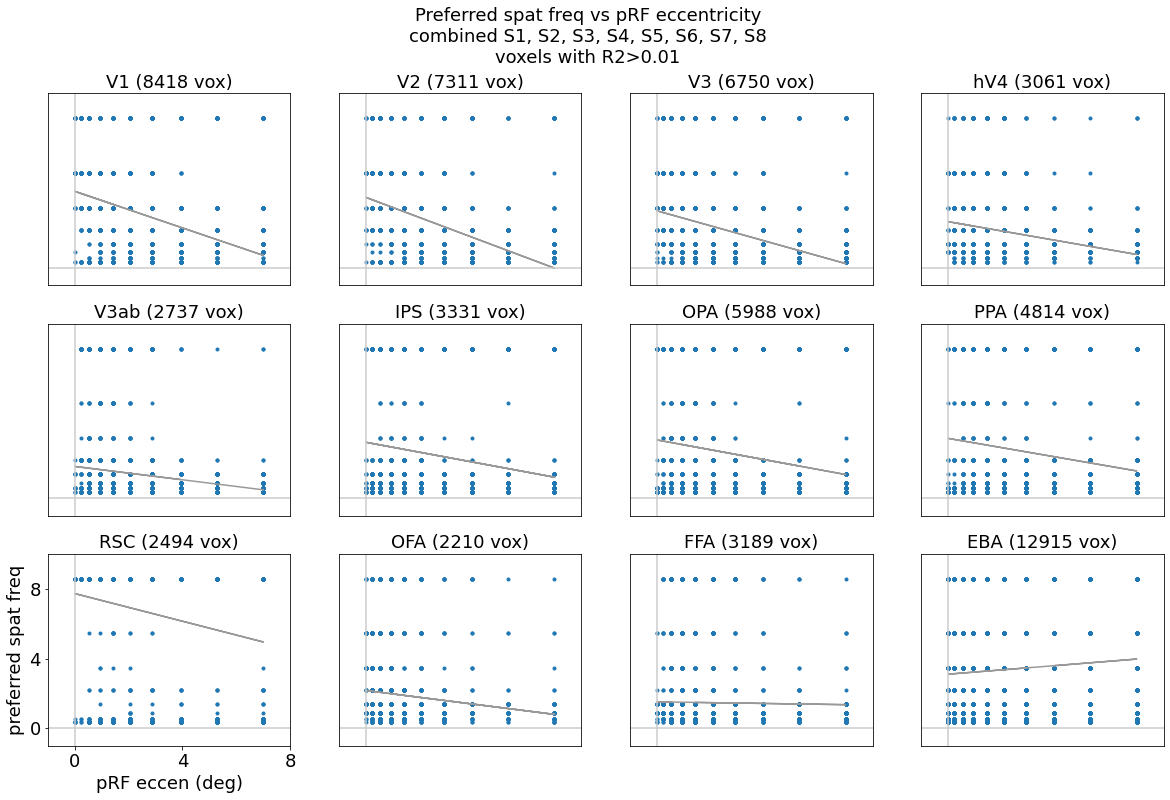

In [21]:
# plot preferred spatial frequency versus pRF eccentricity 

plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.01

xvals = np.concatenate([out[si]['best_params'][0][:,0,0] for si in range(n_subjects)], axis=0)
yvals = np.concatenate([out[si]['best_params'][0][:,0,1] for si in range(n_subjects)], axis=0)
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

best_ecc_deg = np.sqrt(xvals**2+yvals**2)*8.4

dat = np.array([best_ecc_deg, sf_unique[preferred_sf_corr.astype(int)]]).T

inds2use = val_r2 > r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='pRF eccen (deg)', \
                             ylabel='preferred spat freq', \
                             xlims=[-1,8], ylims=[-1,10], \
                  xticks=[0,4,8], yticks=([0,4,8]),\
                  show_diagonal=False, show_axes=True, square=False, 
                  add_best_fit_lines=True);

plot_utils.create_roi_subplots(dat, inds2use, sp, roi_def,\
                   suptitle='Preferred spat freq vs pRF eccentricity\n%s\nvoxels with R2>%.2f'%\
                               (summary_plots.get_substr(out), r2_cutoff), \
                   label_just_corner=True, figsize=(20,12))

# plt.gcf().subplots_adjust(bottom=0.5)


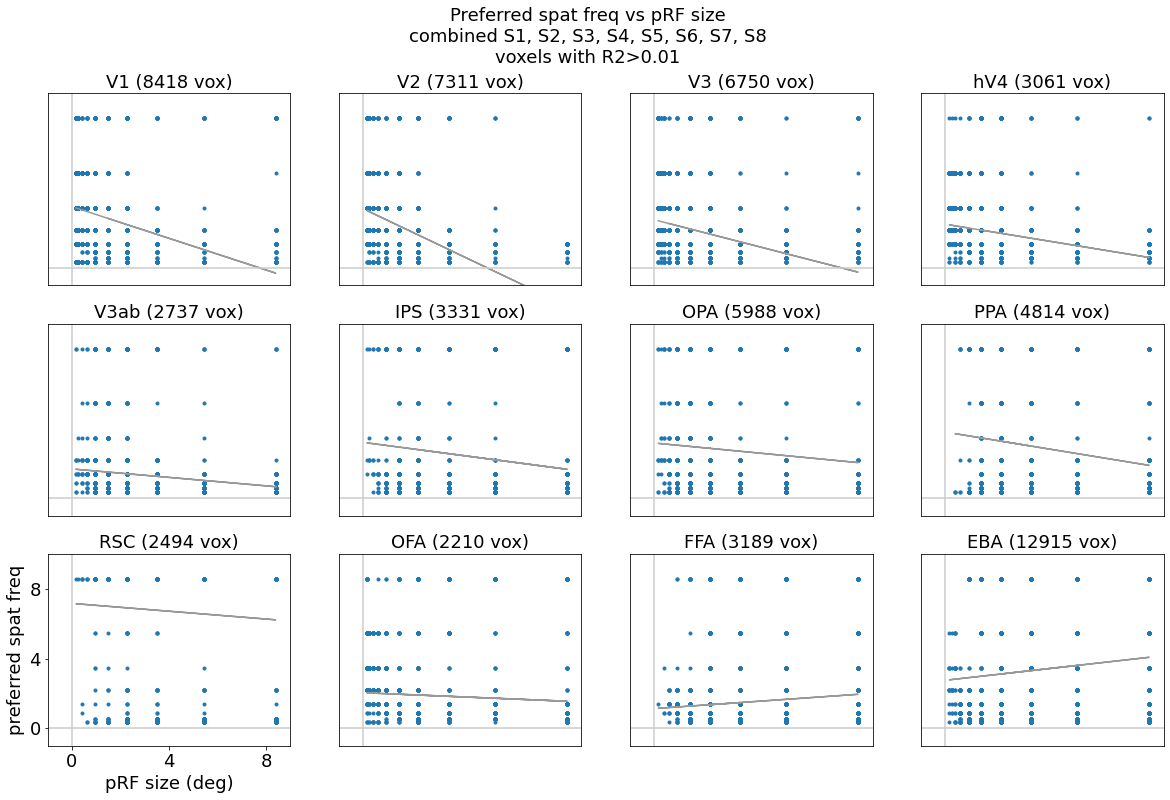

In [22]:
# plot preferred spatial frequency versus pRF size

plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.01

size_vals = np.concatenate([out[si]['best_params'][0][:,0,2] for si in range(n_subjects)], axis=0)

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

best_size_deg = size_vals*8.4

dat = np.array([best_size_deg, sf_unique[preferred_sf_corr.astype(int)]]).T

inds2use = val_r2 > r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='pRF size (deg)', \
                             ylabel='preferred spat freq', \
                             xlims=[-1,9], ylims=[-1,10], \
                  xticks=[0,4,8], yticks=([0,4,8]),\
                  show_diagonal=False, show_axes=True, square=False, \
                add_best_fit_lines=True);

plot_utils.create_roi_subplots(dat, inds2use, sp, roi_def,\
                   suptitle='Preferred spat freq vs pRF size\n%s\nvoxels with R2>%.2f'%\
                               (summary_plots.get_substr(out), r2_cutoff), \
                   label_just_corner=True, figsize=(20,12))


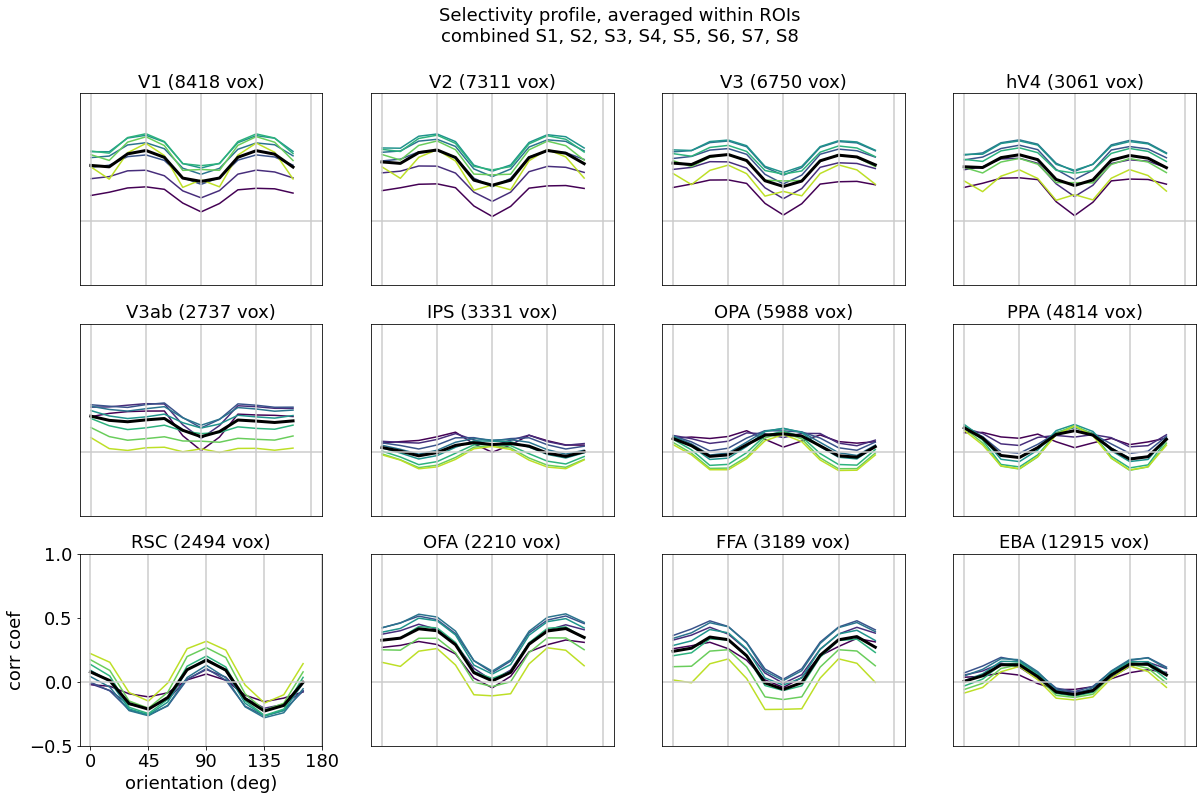

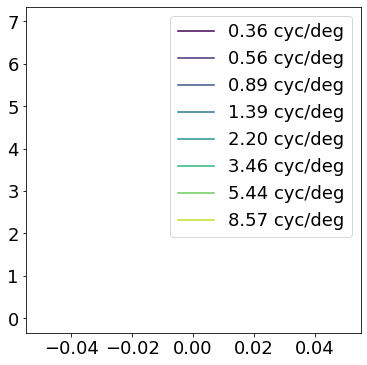

In [23]:
# Plot average orientation tuning curves for each ROI

r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cm.viridis(np.linspace(0,0.9,n_sf))

pi=0
for rr in range(n_rois):
    
    inds_this_roi = roi_def.get_indices(rr) & abv_thresh

    pi+=1
    plt.subplot(npx,npy,pi)

    if np.sum(inds_this_roi)>0:
        for sf in range(n_sf):
            plt.plot(ori_unique, np.mean(allcorr_reshaped[inds_this_roi,:,sf], axis=0),\
                 '-',color=colors[sf,:])
        plt.plot(ori_unique,  np.mean(mean_orient_corr[inds_this_roi,:], axis=0),\
                 '-',color='k',linewidth=3)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('orientation (deg)')
        plt.ylabel('corr coef')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
        plt.yticks([])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

plt.figure(figsize=(6,6));
for sf in range(n_sf):
    plt.plot(0,sf,color=colors[sf,:])    
plt.legend(['%.2f cyc/deg'%sf_unique[sf] for sf in range(n_sf)]);


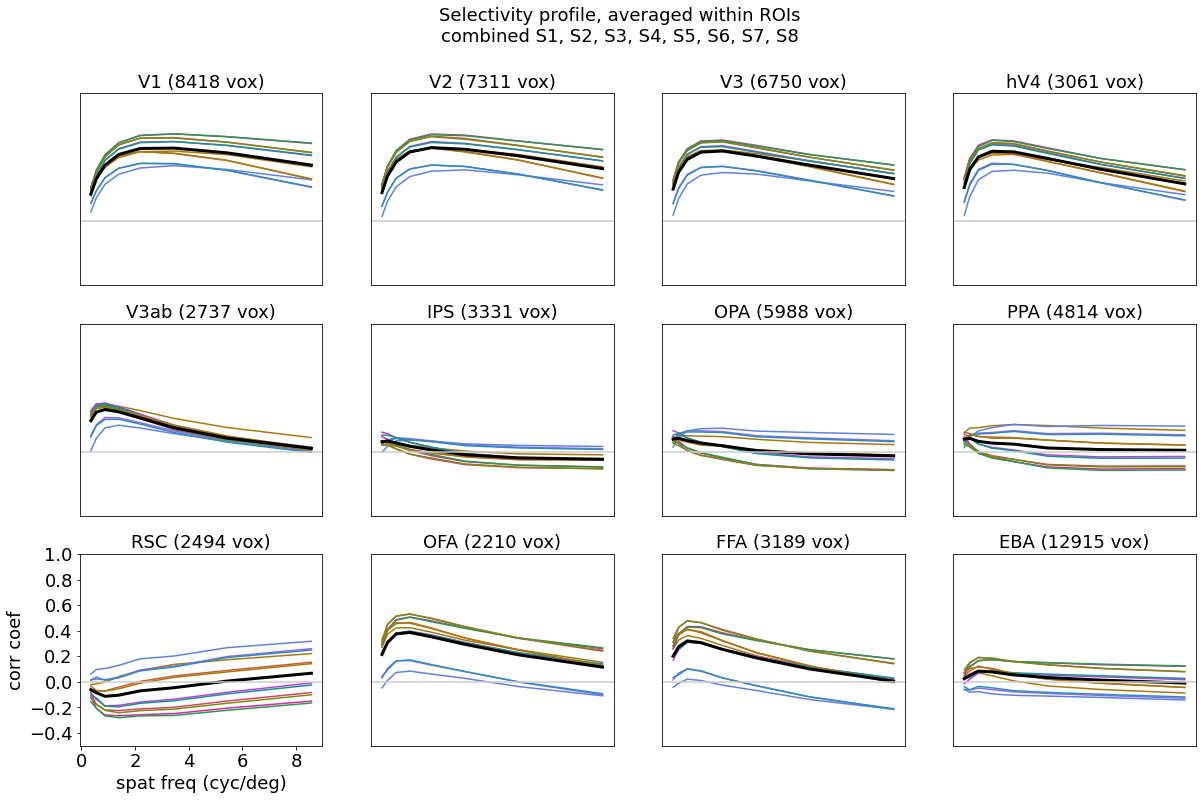

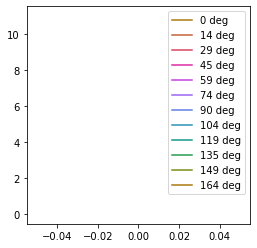

In [24]:
# Plot average spat freq tuning curves for each ROI

plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cmocean.cm.phase(np.linspace(0,1,n_ori))

pi=0
for rr in range(n_rois):
    
    inds_this_roi = roi_def.get_indices(rr) & abv_thresh
       
    pi+=1
    plt.subplot(npx,npy,pi)

    if np.sum(inds_this_roi)>0:
        for oo in range(n_ori):
            plt.plot(sf_unique, np.mean(allcorr_reshaped[inds_this_roi,oo,:], axis=0).T,\
                 '-',color=colors[oo,:])
        plt.plot(sf_unique,  np.mean(mean_sf_corr[inds_this_roi,:], axis=0),\
                 '-',color='k',linewidth=3)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('spat freq (cyc/deg)')
        plt.ylabel('corr coef')
    else:
        plt.xticks([]);
        plt.yticks([])

    plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Selectivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

plot_utils.set_all_font_sizes(fs = 10)
plt.figure(figsize=(4,4));
for oo in range(n_ori):
    plt.plot(0,oo,color=colors[oo,:])    
plt.legend(['%d deg'%ori_unique[oo] for oo in range(n_ori)]);


Text(0.5, 0.98, 'Selectivity profile, randomly sampled individual voxels\ncombined S1, S2, S3, S4, S5, S6, S7, S8\nR2>0.10')

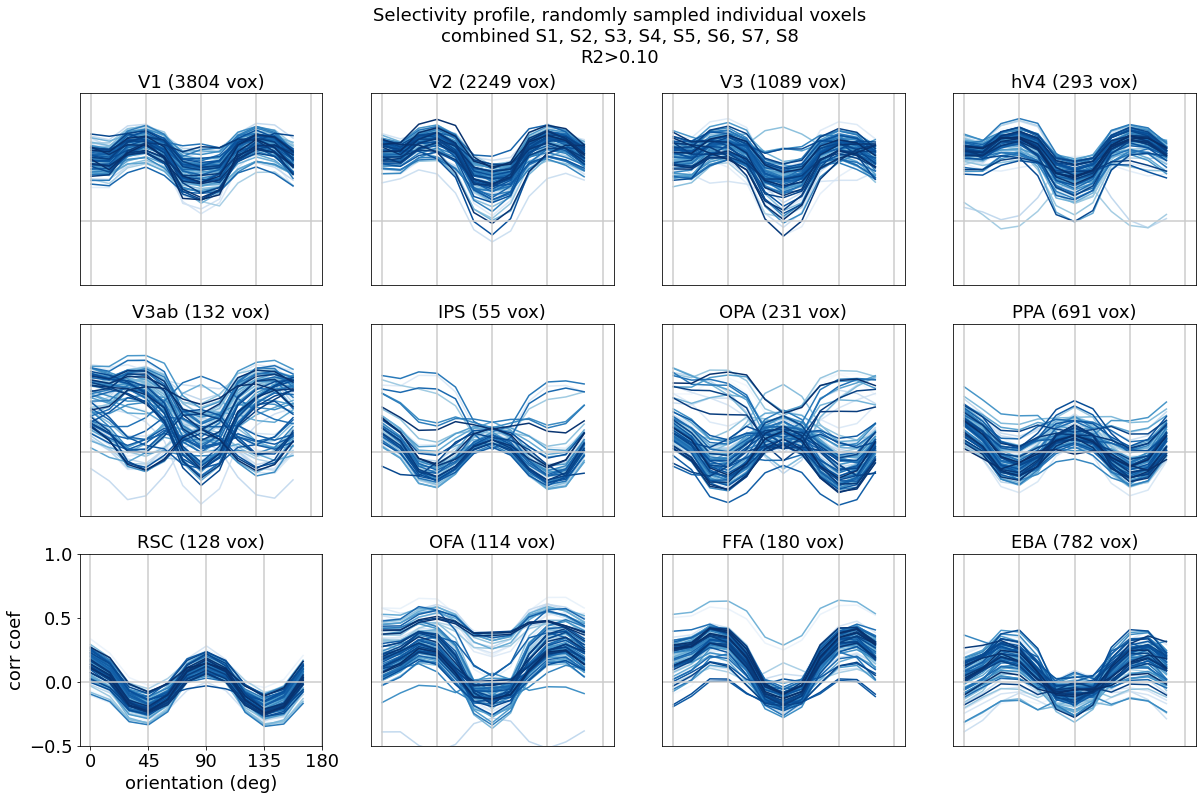

In [25]:
# Plot individual voxels' orientation tuning curves for each ROI

plot_utils.set_all_font_sizes(fs = 18)

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

max2plot = 100;

pi=0
for rr in range(n_rois):
    
    inds_this_roi = roi_def.get_indices(rr) & abv_thresh

    pi+=1
    plt.subplot(npx,npy,pi)

    if np.sum(inds_this_roi)>0:

        vox2plot = np.where(inds_this_roi)[0]
        np.random.seed(982355)
        n2plot=np.minimum(max2plot,len(vox2plot))
       
        vox2plot = np.random.choice(vox2plot, n2plot, replace=False)
        colors = cm.Blues(np.linspace(0,1,len(vox2plot)))
        for vi,vv in enumerate(vox2plot):
            plt.plot(ori_unique, mean_orient_corr[vv,:].T,\
                 '-',color=colors[vi,:])

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('orientation (deg)')
        plt.ylabel('corr coef')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
        plt.yticks([])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Selectivity profile, randomly sampled individual voxels\n%s\nR2>%.2f'%(summary_plots.get_substr(out),\
             r2_cutoff))


Text(0.5, 0.98, 'Selectivity profile, randomly sampled individual voxels\ncombined S1, S2, S3, S4, S5, S6, S7, S8\nR2>0.10')

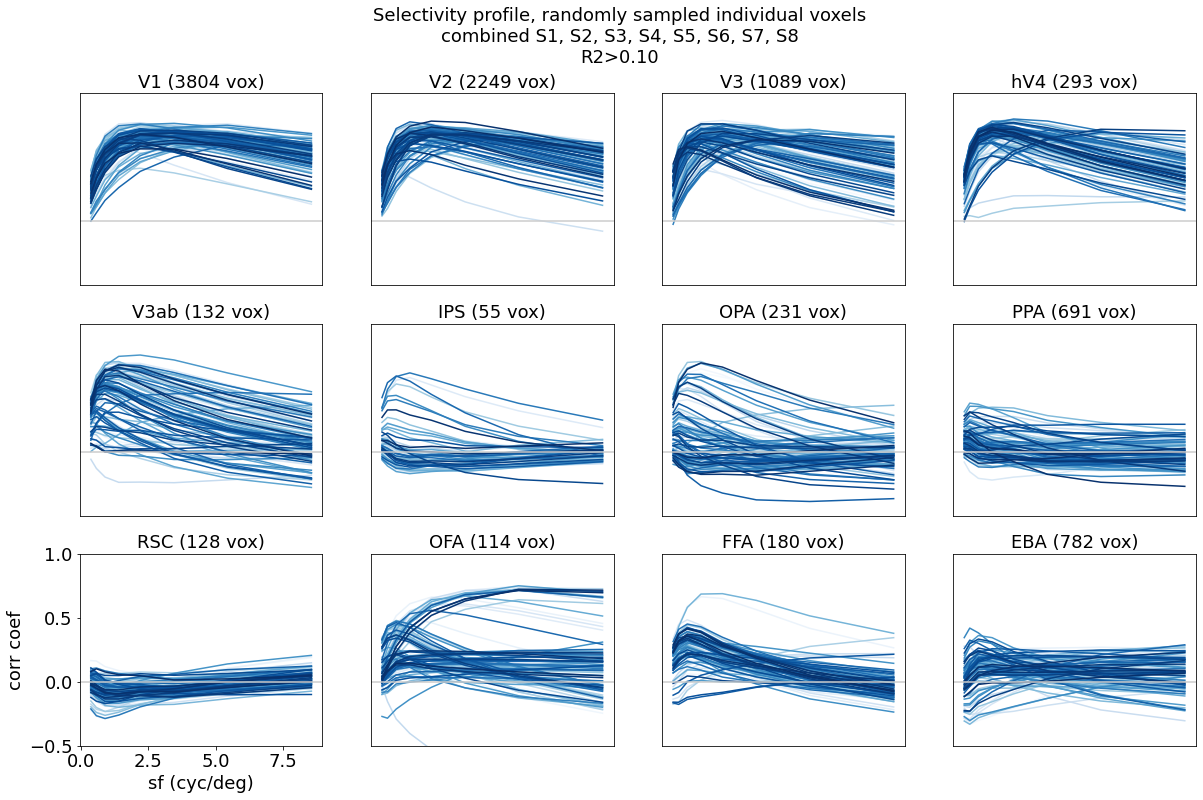

In [26]:
# Plot individual voxels' orientation tuning curves for each ROI

plot_utils.set_all_font_sizes(fs = 18)

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

max2plot = 100;

pi=0
for rr in range(n_rois):
    
    inds_this_roi = roi_def.get_indices(rr) & abv_thresh

    pi+=1
    plt.subplot(npx,npy,pi)

    if np.sum(inds_this_roi)>0:

        vox2plot = np.where(inds_this_roi)[0]
        np.random.seed(982355)
        n2plot=np.minimum(max2plot,len(vox2plot))
       
        vox2plot = np.random.choice(vox2plot, n2plot, replace=False)
        colors = cm.Blues(np.linspace(0,1,len(vox2plot)))
        for vi,vv in enumerate(vox2plot):
            plt.plot(sf_unique, mean_sf_corr[vv,:].T,\
                 '-',color=colors[vi,:])

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('sf (cyc/deg)')
        plt.ylabel('corr coef')
    else:
        plt.xticks([]);
        plt.yticks([])

    plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Selectivity profile, randomly sampled individual voxels\n%s\nR2>%.2f'%(summary_plots.get_substr(out),\
             r2_cutoff))


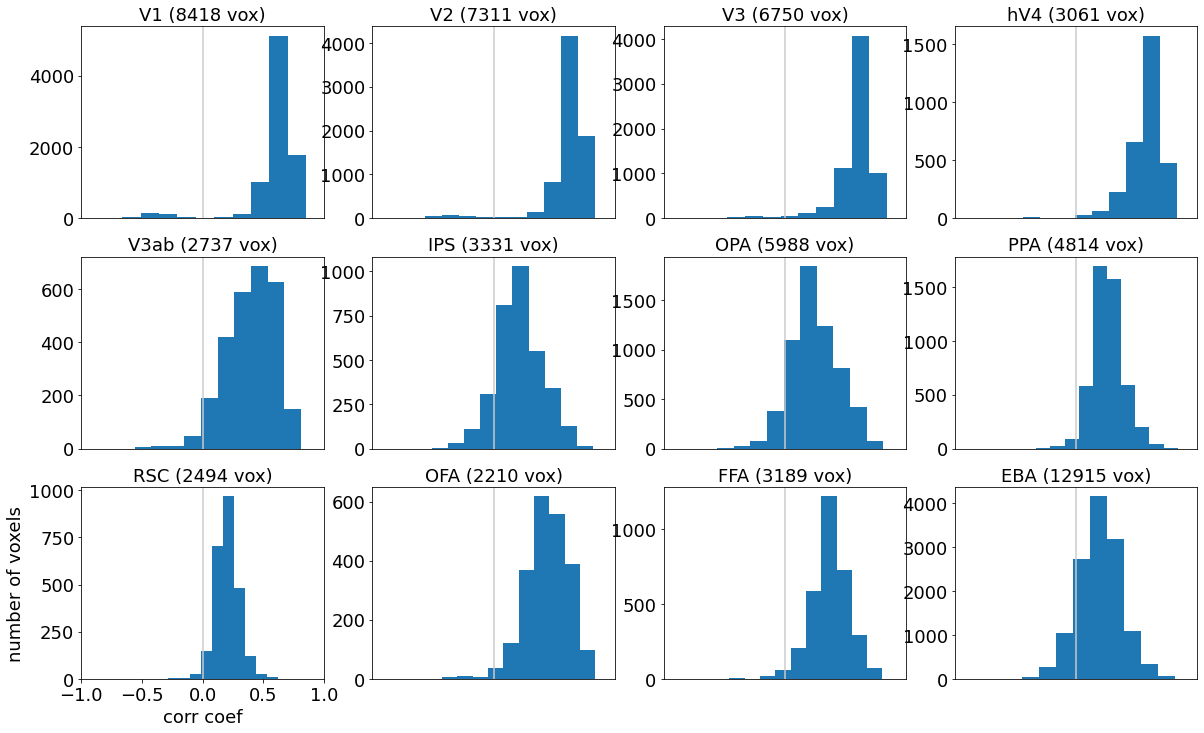

In [27]:
# plotting the distribution of voxel's maximum corr coef, for any orientation

r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.max(mean_orient_corr[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))


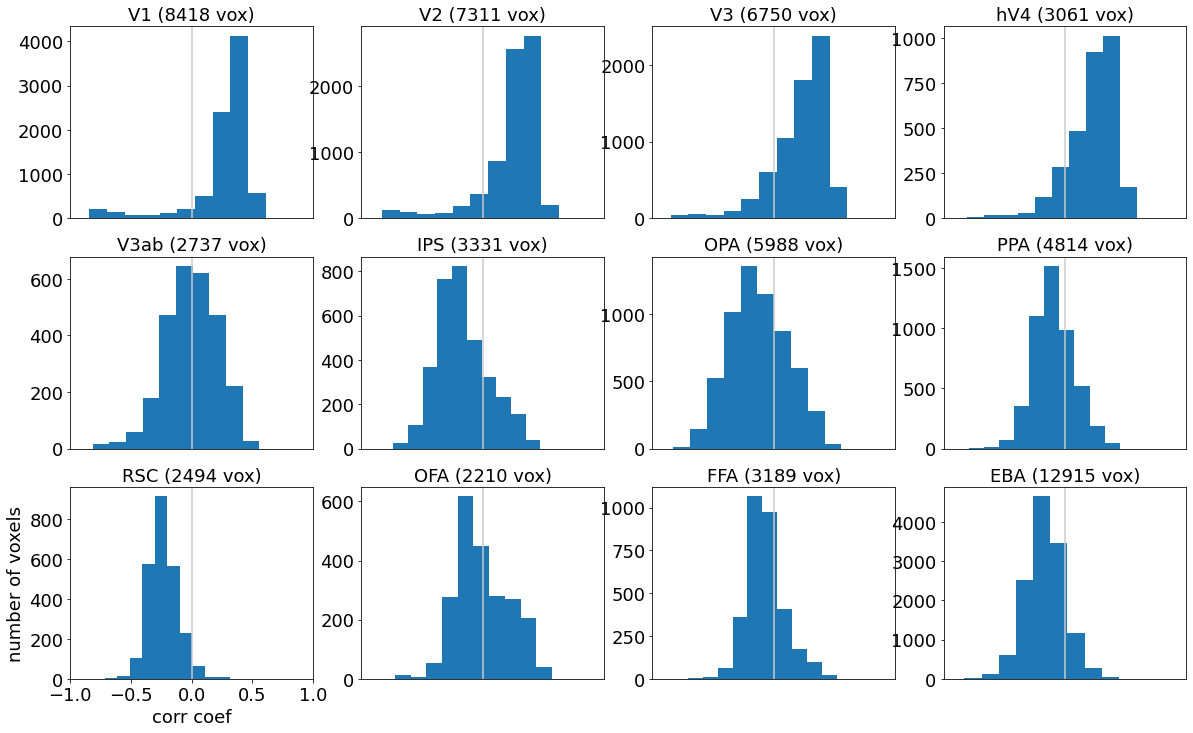

In [28]:
# plotting the distribution of voxel's minimum corr coef, for any orientation

r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.min(mean_orient_corr[inds_this_roi], axis=1)
    
    plt.hist(vals)
    plt.xlim([-1,1])

    if pi==(npx-1)*npy+1:
        plt.xlabel('corr coef')
        plt.ylabel('number of voxels')
    else:
        plt.xticks([]);

    plt.axvline(0,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))


In [29]:
# for comparison, also looking at raw encoding model weights - not as interpretable

feature_weights = np.concatenate([out[si]['best_params'][1][:,:,0] for si in range(n_subjects)], axis=0)
allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')
mean_orient_weights = np.mean(allw_reshaped, axis=2)
mean_sf_weights = np.mean(allw_reshaped, axis=1)


preferred_ori_weights = np.argmax(mean_orient_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_weights[:,0:1], [1,n_ori])==mean_orient_weights, axis=1)
preferred_ori_weights[is_constant] = np.nan

preferred_sf_weights = np.argmax(mean_sf_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_weights[:,0:1], [1,n_sf])==mean_sf_weights, axis=1)
preferred_sf_weights[is_constant] = np.nan

0.3565896056935289


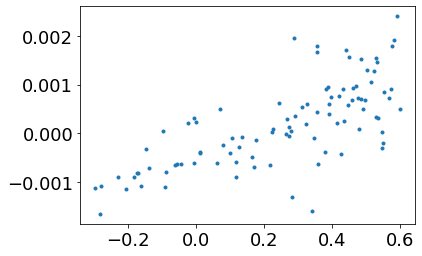

In [30]:
# about how well are the weights for different channels aligned with the correlation coefficient 
# measure of feature tuning?
correspondence = [np.corrcoef(feature_weights[ii,:], feature_corr[ii,:])[0,1] for ii in range(n_voxels)]
print(np.mean(correspondence) )

# correlation and weights don't necessarily correspond.
vidx = np.random.choice(np.arange(n_voxels),1)
plt.plot(allcorr_reshaped[vidx,:,:].ravel(), allw_reshaped[vidx,:,:].ravel(),'.')

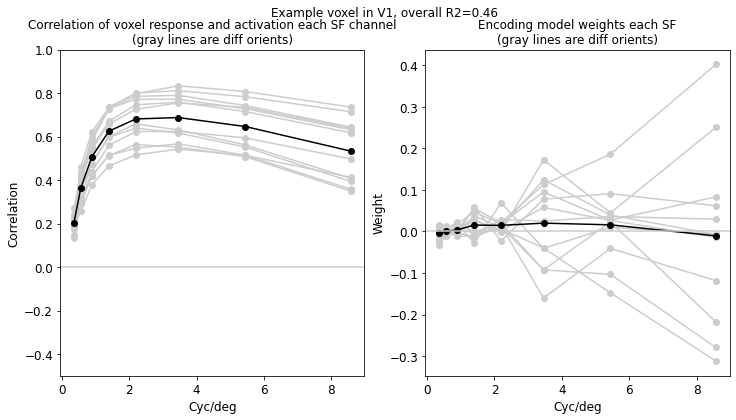

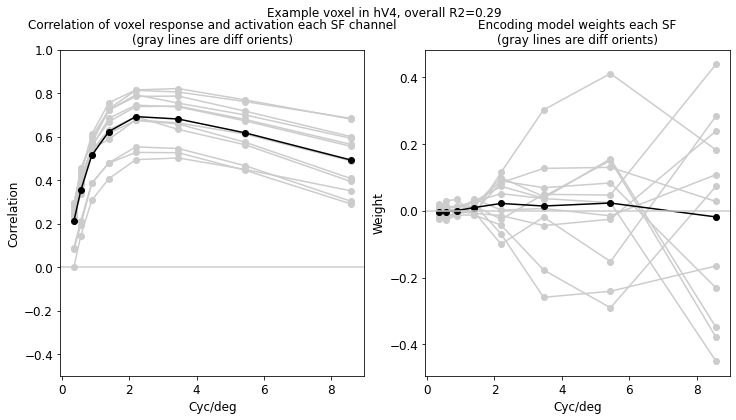

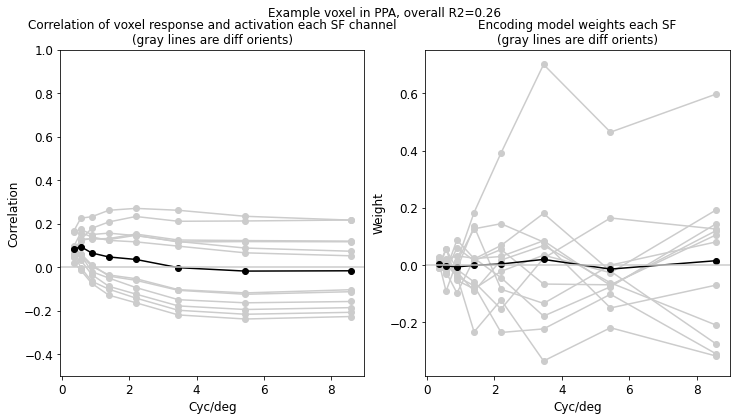

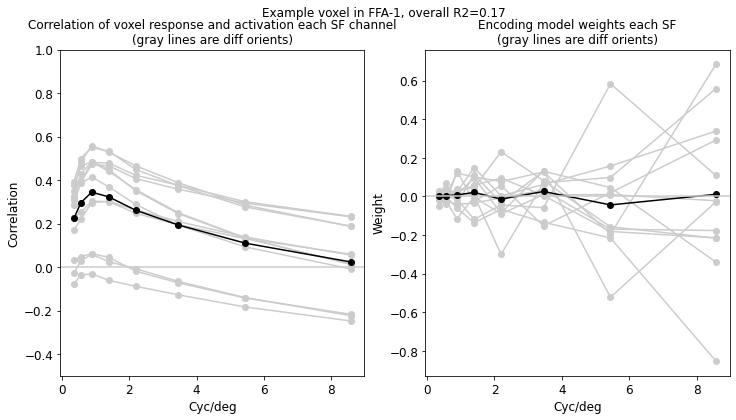

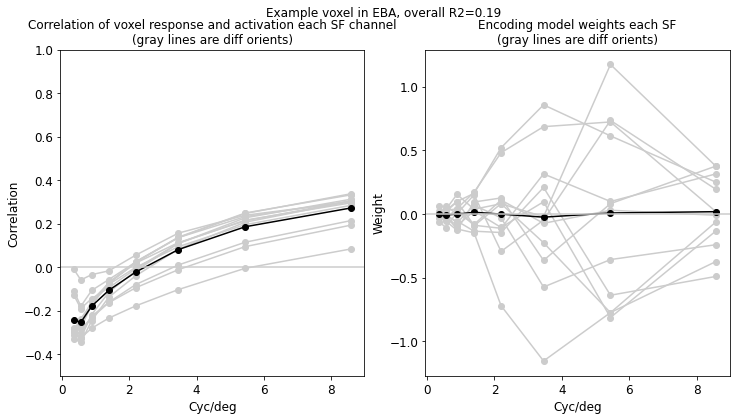

In [43]:
# Plotting spatial frequency tuning (and weights) for some example voxels

plot_utils.set_all_font_sizes(12)

si = 0;

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

rnames = ['V1', 'hV4', 'PPA','FFA-1','EBA']

for rname in rnames:

    vinds = np.where(roi_def.get_indices_from_name(rname))[0]

    vidx = vinds[np.flip(np.argsort(val_r2[vinds]))[0]]

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(sf_unique, allcorr_reshaped[vidx,:,:].T,'-o',color=[0.8, 0.8, 0.8])
    plt.plot(sf_unique,  mean_sf_corr[vidx,:],'-o',color='k')
    plt.xlabel('Cyc/deg')
    plt.ylabel('Correlation')
    plt.title('Correlation of voxel response and activation each SF channel\n(gray lines are diff orients)')
    # plt.axhline(val_cc[vidx],color='k')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
   
    plt.ylim([-0.5,1])

    plt.subplot(1,2,2)
    plt.plot(sf_unique, allw_reshaped[vidx,:,:].T,'-o',color=[0.8, 0.8, 0.8])
    plt.plot(sf_unique, mean_sf_weights[vidx,:],'-o',color='k')
    plt.xlabel('Cyc/deg')
    plt.ylabel('Weight')
    plt.title('Encoding model weights each SF\n(gray lines are diff orients)')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
   
    plt.suptitle('Example voxel in %s, overall R2=%.2f'%(rname, val_r2[vidx]));



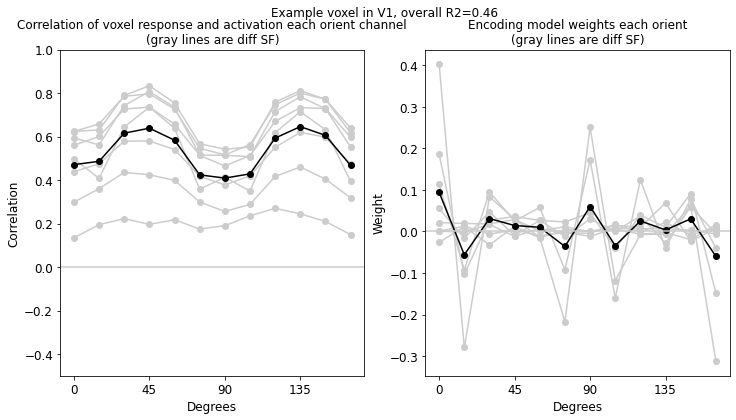

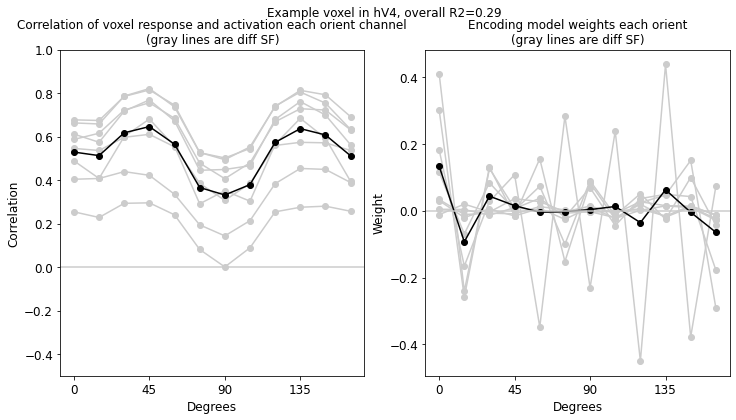

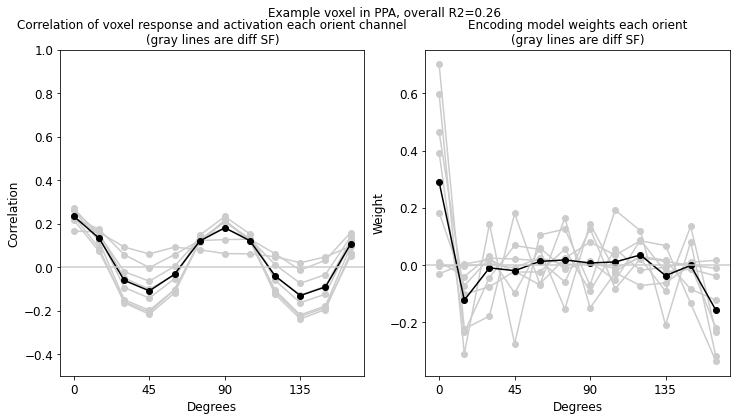

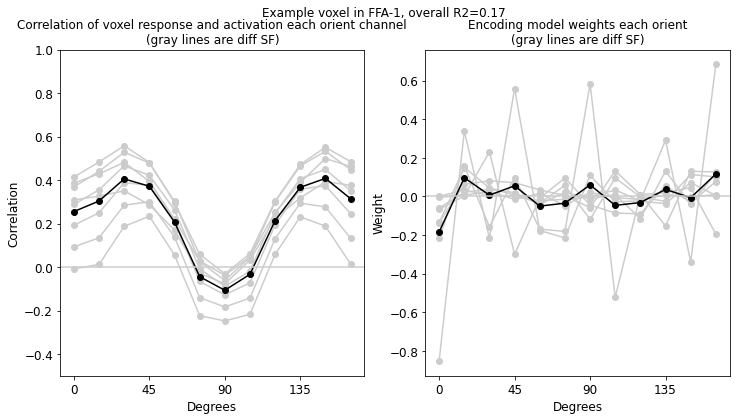

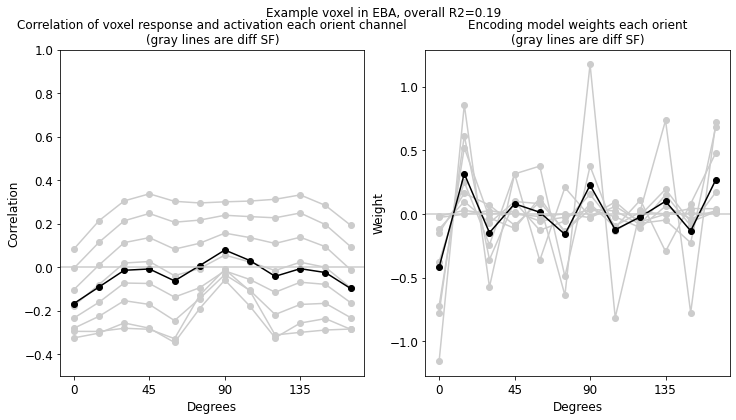

In [44]:
# Plotting orientation tuning (and weight profile) for some example voxels

plot_utils.set_all_font_sizes(12)

si = 0;

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

rnames = ['V1', 'hV4', 'PPA', 'FFA-1', 'EBA']

for rname in rnames:

    vinds = np.where(roi_def.get_indices_from_name(rname))[0]

    vidx = vinds[np.flip(np.argsort(val_r2[vinds]))[0]]

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(ori_unique, allcorr_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(ori_unique,  mean_orient_corr[vidx,:],'-o',color='k')
    plt.xlabel('Degrees')
    plt.ylabel('Correlation')
    plt.title('Correlation of voxel response and activation each orient channel\n(gray lines are diff SF)')
    # plt.axhline(val_cc[vidx],color='k')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.xticks(np.arange(0,179,45))
    plt.ylim([-0.5,1])

    plt.subplot(1,2,2)
    plt.plot(ori_unique, allw_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(ori_unique, mean_orient_weights[vidx,:],'-o',color='k')
    plt.xlabel('Degrees')
    plt.ylabel('Weight')
    plt.title('Encoding model weights each orient\n(gray lines are diff SF)')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.xticks(np.arange(0,179,45))
    # plt.ylim([-1,1])

    plt.suptitle('Example voxel in %s, overall R2=%.2f'%(rname, val_r2[vidx]));

